In [1]:
import matplotlib.pyplot as plt
import numpy as np
from helpers import get_error_rate, get_error_rate_per_qubit, fit_reverse_gates
from matplotlib.pyplot import figure
import matplotlib as mpl
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
import copy
import pickle
from qiskit.providers.ibmq import IBMQ, least_busy
from IPython.display import display
from numpy.polynomial import Polynomial
import datetime
from threading import Thread
import math

In [2]:
provider = IBMQ.load_account()

In [3]:
hw = least_busy(provider.backends(n_qubits=5, operational=True, simulator=False))

In [4]:
props = hw.properties()

In [5]:
noise = NoiseModel.from_backend(hw)
sim = AerSimulator.from_backend(hw)

In [6]:
n_qubits = hw.configuration().n_qubits

In [7]:
chained_x_all = []
for i in range(n_qubits):
	chained_x = []
	for j in range(50):
		qc = QuantumCircuit(5, 1)
		for _ in range(j):
			qc.x(i)
			qc.barrier()
			qc.x(i)
			qc.barrier()
		qc.measure(i, 0)
		chained_x.append(qc)
	chained_x_all.append(chained_x)


chained_id_gates = []

for i in range(100):
	qc = QuantumCircuit(1, 1)
	for _ in range(i):
		qc.id(0)
		qc.barrier()
	qc.measure(0, 0)
	chained_id_gates.append(qc)

In [8]:
chained_x_all_transpiled = [transpile(c, sim, optimization_level=0) for c in chained_x_all]
chained_id_gates_transpiled = transpile(chained_id_gates, sim, optimization_level=0)

In [9]:
jobs = [sim.run(ct, shots=10000) for ct in chained_x_all_transpiled]
job_id = sim.run(chained_id_gates_transpiled, shots=10000)

In [10]:
ress = [job.result().get_counts() for job in jobs]
res_id = job_id.result().get_counts()

In [11]:
expected = [{"0": 1}] * 50

In [12]:
error = np.array([[get_error_rate(r, e) for r, e in zip(res, expected)] for res in ress])
error_id = np.array([get_error_rate(r, {"0" : 1}) for r in res_id])

In [13]:
bit_errors = np.array([1 - ((1 - noise._local_quantum_errors["x"][(i,)].probabilities[0]) / 2) for i in range(n_qubits)])
prep0_measure_error = np.array([noise._local_readout_errors[(i,)].probabilities[0, 0] for i in range(n_qubits)])
prep1_measure_error = np.array([noise._local_readout_errors[(i,)].probabilities[1, 1] for i in range(n_qubits)])
c_lengths = np.arange(0, 100, 2)

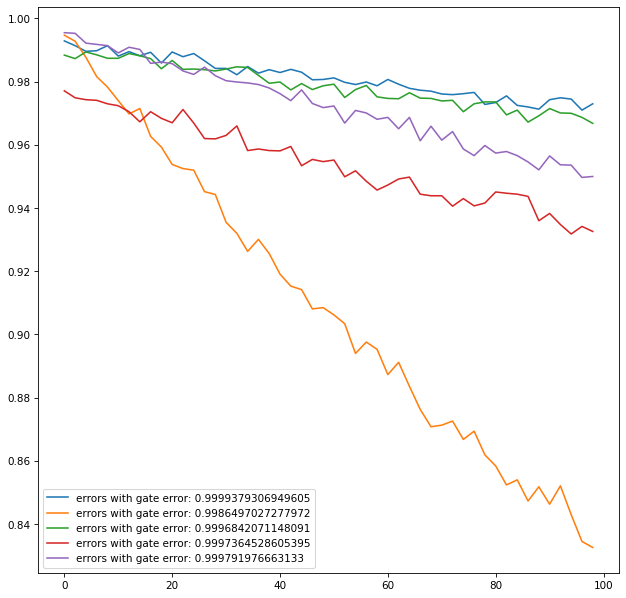

In [14]:
figure(figsize=(10, 10), dpi=75)

for i in range(n_qubits):
	plt.plot(c_lengths, error[i], label=f"errors with gate error: {bit_errors[i]}")

plt.legend()
#plt.savefig("../../images/tmp/raw_error.jpg")

In [15]:
def fix_readout_error(error: np.ndarray, expected=0, qubit=0, clip_values=False):
	if expected != 0 and expected != 1:
		raise Exception(f"The expected reaoud is not valid {expected}")

	prep0_measure_error = np.array(noise._local_readout_errors[(qubit,)].probabilities[0, 0])
	prep1_measure_error = np.array(noise._local_readout_errors[(qubit,)].probabilities[1, 1])

	if expected == 0:
		real = (error - (1 - prep1_measure_error)) / (prep0_measure_error - (1 - prep1_measure_error))
	else: 
		real = (error - (1 - prep0_measure_error)) / (prep1_measure_error - (1 - prep0_measure_error))

	if clip_values:
		real[real>1] = 1
		real[real<0] = 0

	assert real.min() >= 0, "_fix_readout_error under 0"
	assert real.max() <= 1, "_fix_readout_error over 1"
	return real

In [16]:
fixed_errs = [fix_readout_error(error[i], 0, i, clip_values=True) for i in range(n_qubits)]

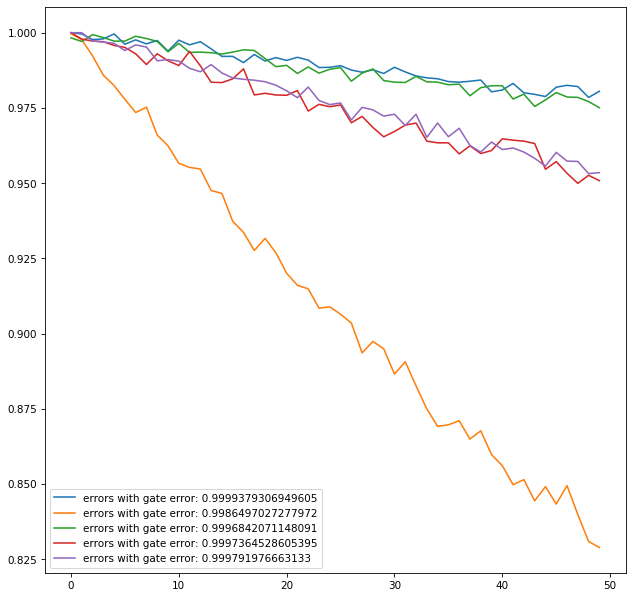

In [17]:
figure(figsize=(10, 10), dpi=75)

for i in range(n_qubits):
	plt.plot(fixed_errs[i], label=f"errors with gate error: {bit_errors[i]}")

plt.legend()
#plt.savefig("../../images/tmp/error_without_readout.jpg")


In [18]:
def number_of_combinations(true, count):
	return math.factorial(count) / (math.factorial(true) * math.factorial(count - true))

def f_universal(real, x_cnt):
	measured = 0
	if x_cnt % 2 == 0:
		for i in range(0, x_cnt+1, 2):
			measured += number_of_combinations(i, x_cnt) * real**i * (1-real)**(x_cnt-i)
	else:
		measured = real**x_cnt
		for i in range(1, x_cnt-1, 2):
			measured += number_of_combinations(i, x_cnt) * real**i * (1-real)**(x_cnt-i)

	return measured

def fit_reverse_gates(x_cnt):
	x = np.arange(0.9, 1.00000001, 0.0001)
	return Polynomial.fit(f_universal(x, x_cnt), x, x_cnt**2)

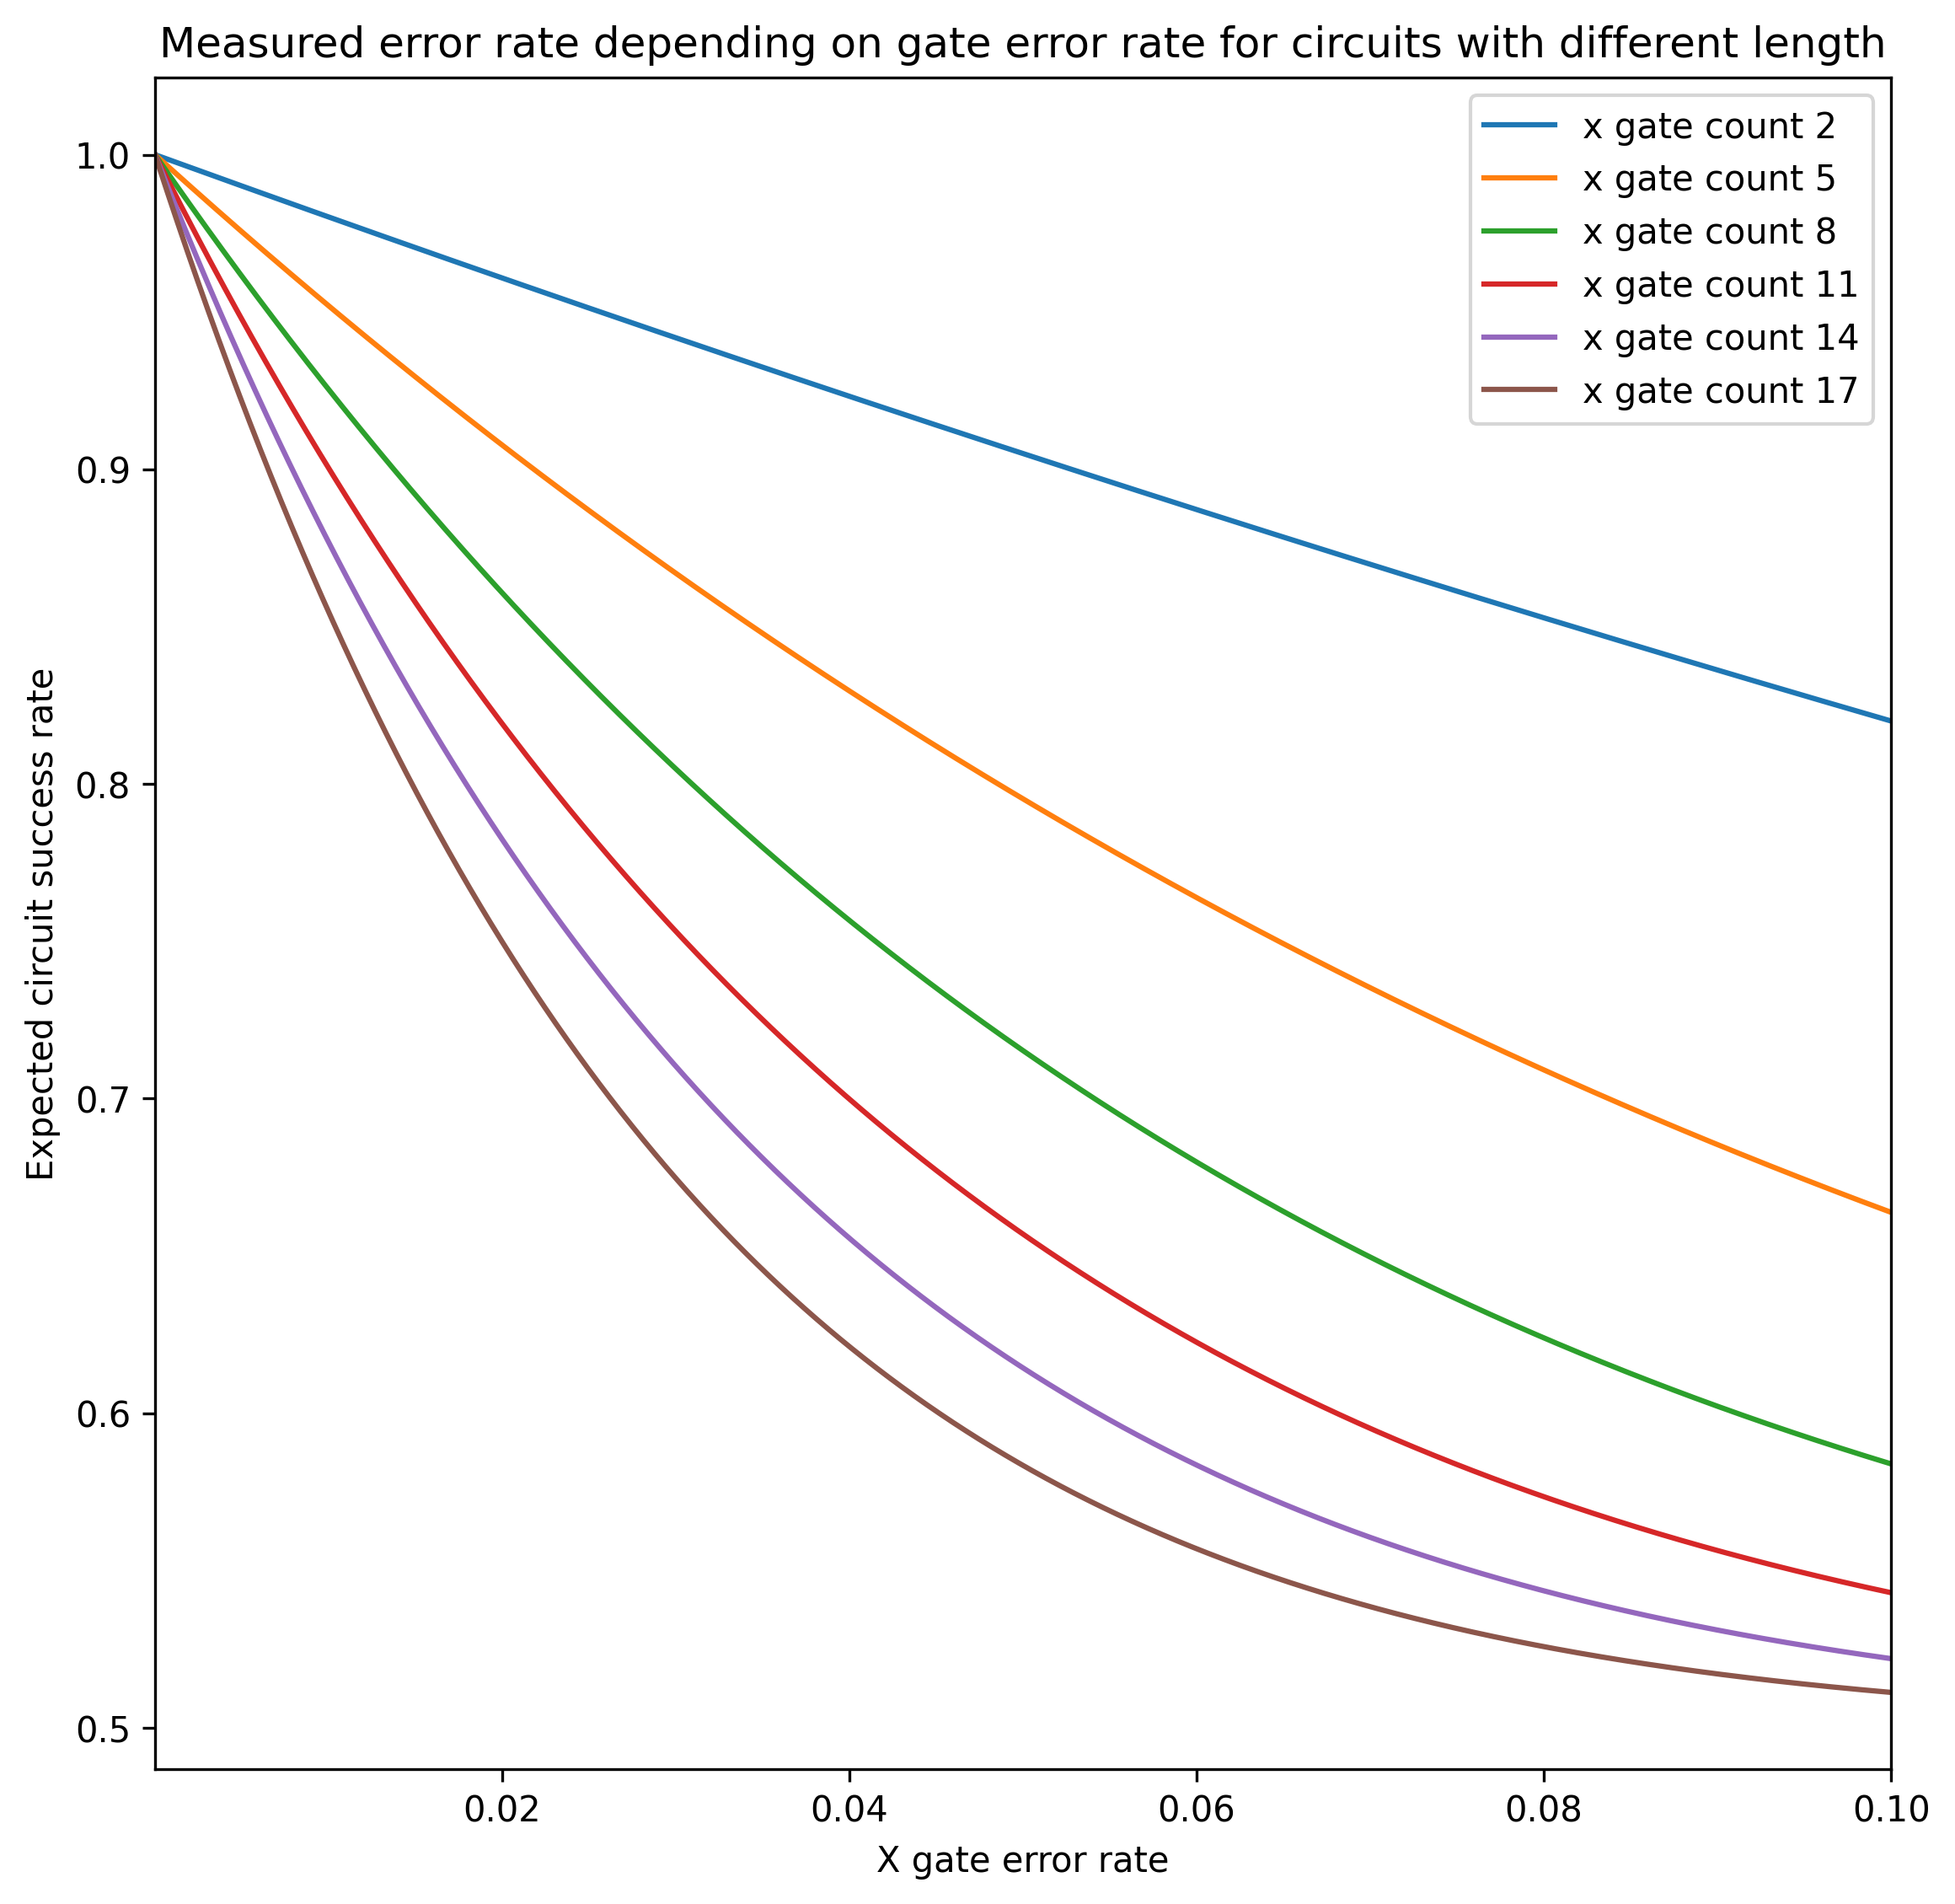

In [19]:
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
figure(figsize=(figure_width, figure_heigth), dpi=dpi)
l = np.arange(0.9, 1, 0.00001)
for i in range(2, 20, 3):
	plt.plot((1-l), (f_universal(l, i)), label=f"x gate count {i}")

plt.xlim((1-l)[-1],(1-l)[0])
plt.title("Measured error rate depending on gate error rate for circuits with different length")
plt.ylabel("Expected circuit success rate")
plt.xlabel("X gate error rate")
plt.legend()
plt.savefig("../images/expected_error_with_n_length.png", bbox_inches='tight')


/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


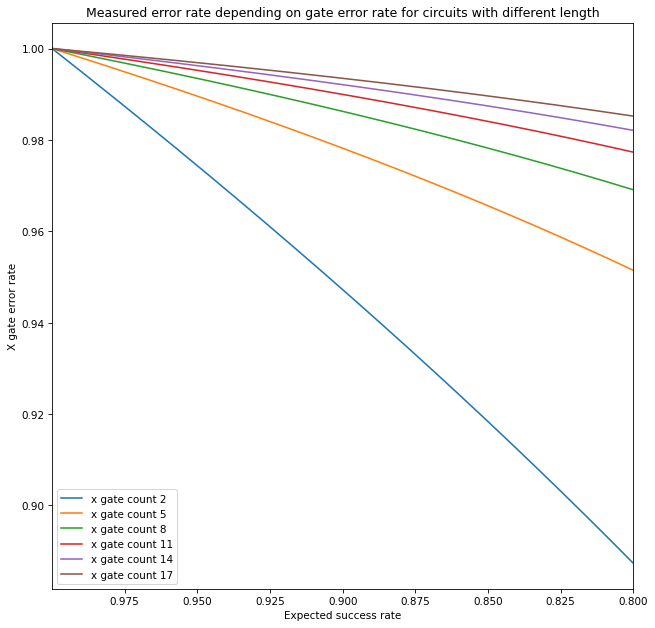

In [20]:
figure(figsize=(10, 10), dpi=75)
l = np.arange(0.8, 1, 0.00001)
for i in range(2, 20, 3):
	plt.plot(l, (fit_reverse_gates(i)(l)), label=f"x gate count {i}")

plt.xlim(l[-1],l[0])
plt.title("Measured error rate depending on gate error rate for circuits with different length")
plt.xlabel("Expected success rate")
plt.ylabel("X gate error rate")
plt.legend()
#plt.savefig("../../images/expected_error_with_n_length.jpg")

In [21]:
fits = {i: fit_reverse_gates(i) for i in range(2, 100, 2)}

/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/jakob/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


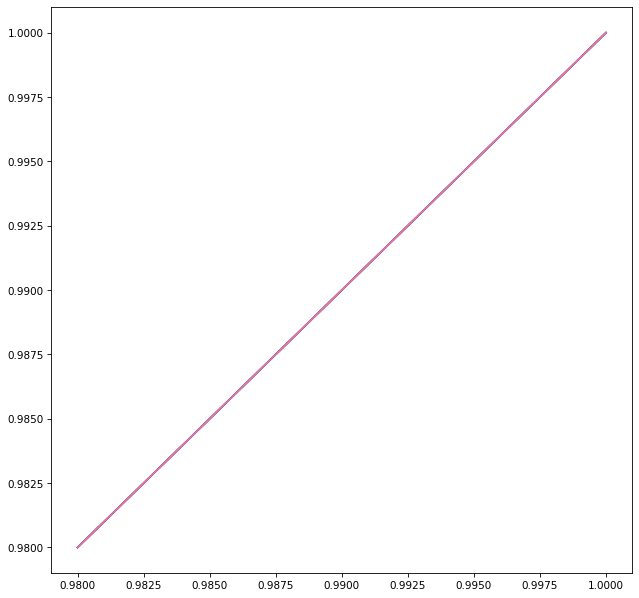

In [22]:
figure(figsize=(10, 10), dpi=75)

for i in range(2, 15, 2):
	l = np.arange(0.98, 1, 0.00001)
	plt.plot(l, fit_reverse_gates(i)(f_universal(l, i)))

In [23]:
circs = []
for i in range(50):
	qc = QuantumCircuit(1,1)
	for _ in range(i):
		qc.x(0)
		qc.barrier()
	qc.measure(0,0)
	circs.append(qc)

circs = transpile(circs, sim, optimization_level=0)

In [24]:
res_noisy = sim.run(circs, shots=10000, seed_simulator=3).result().get_counts()

In [25]:
error_noisy = np.array([get_error_rate(r, {"1": 1}) for r in res_noisy[1::2]])
exp = [{"0":1}, {"1": 1}]*25
error_noisy_all = np.array([get_error_rate(r, e) for r, e in zip(res_noisy, exp)])
odd_l = range(1, 50, 2) 
fit_noisy = Polynomial.fit(odd_l, error_noisy, 2)

In [26]:
readout_error_0 = NoiseModel.from_backend(sim)._local_readout_errors[(0,)].probabilities[0, 0]
readout_error_1 = NoiseModel.from_backend(sim)._local_readout_errors[(0,)].probabilities[1, 1]

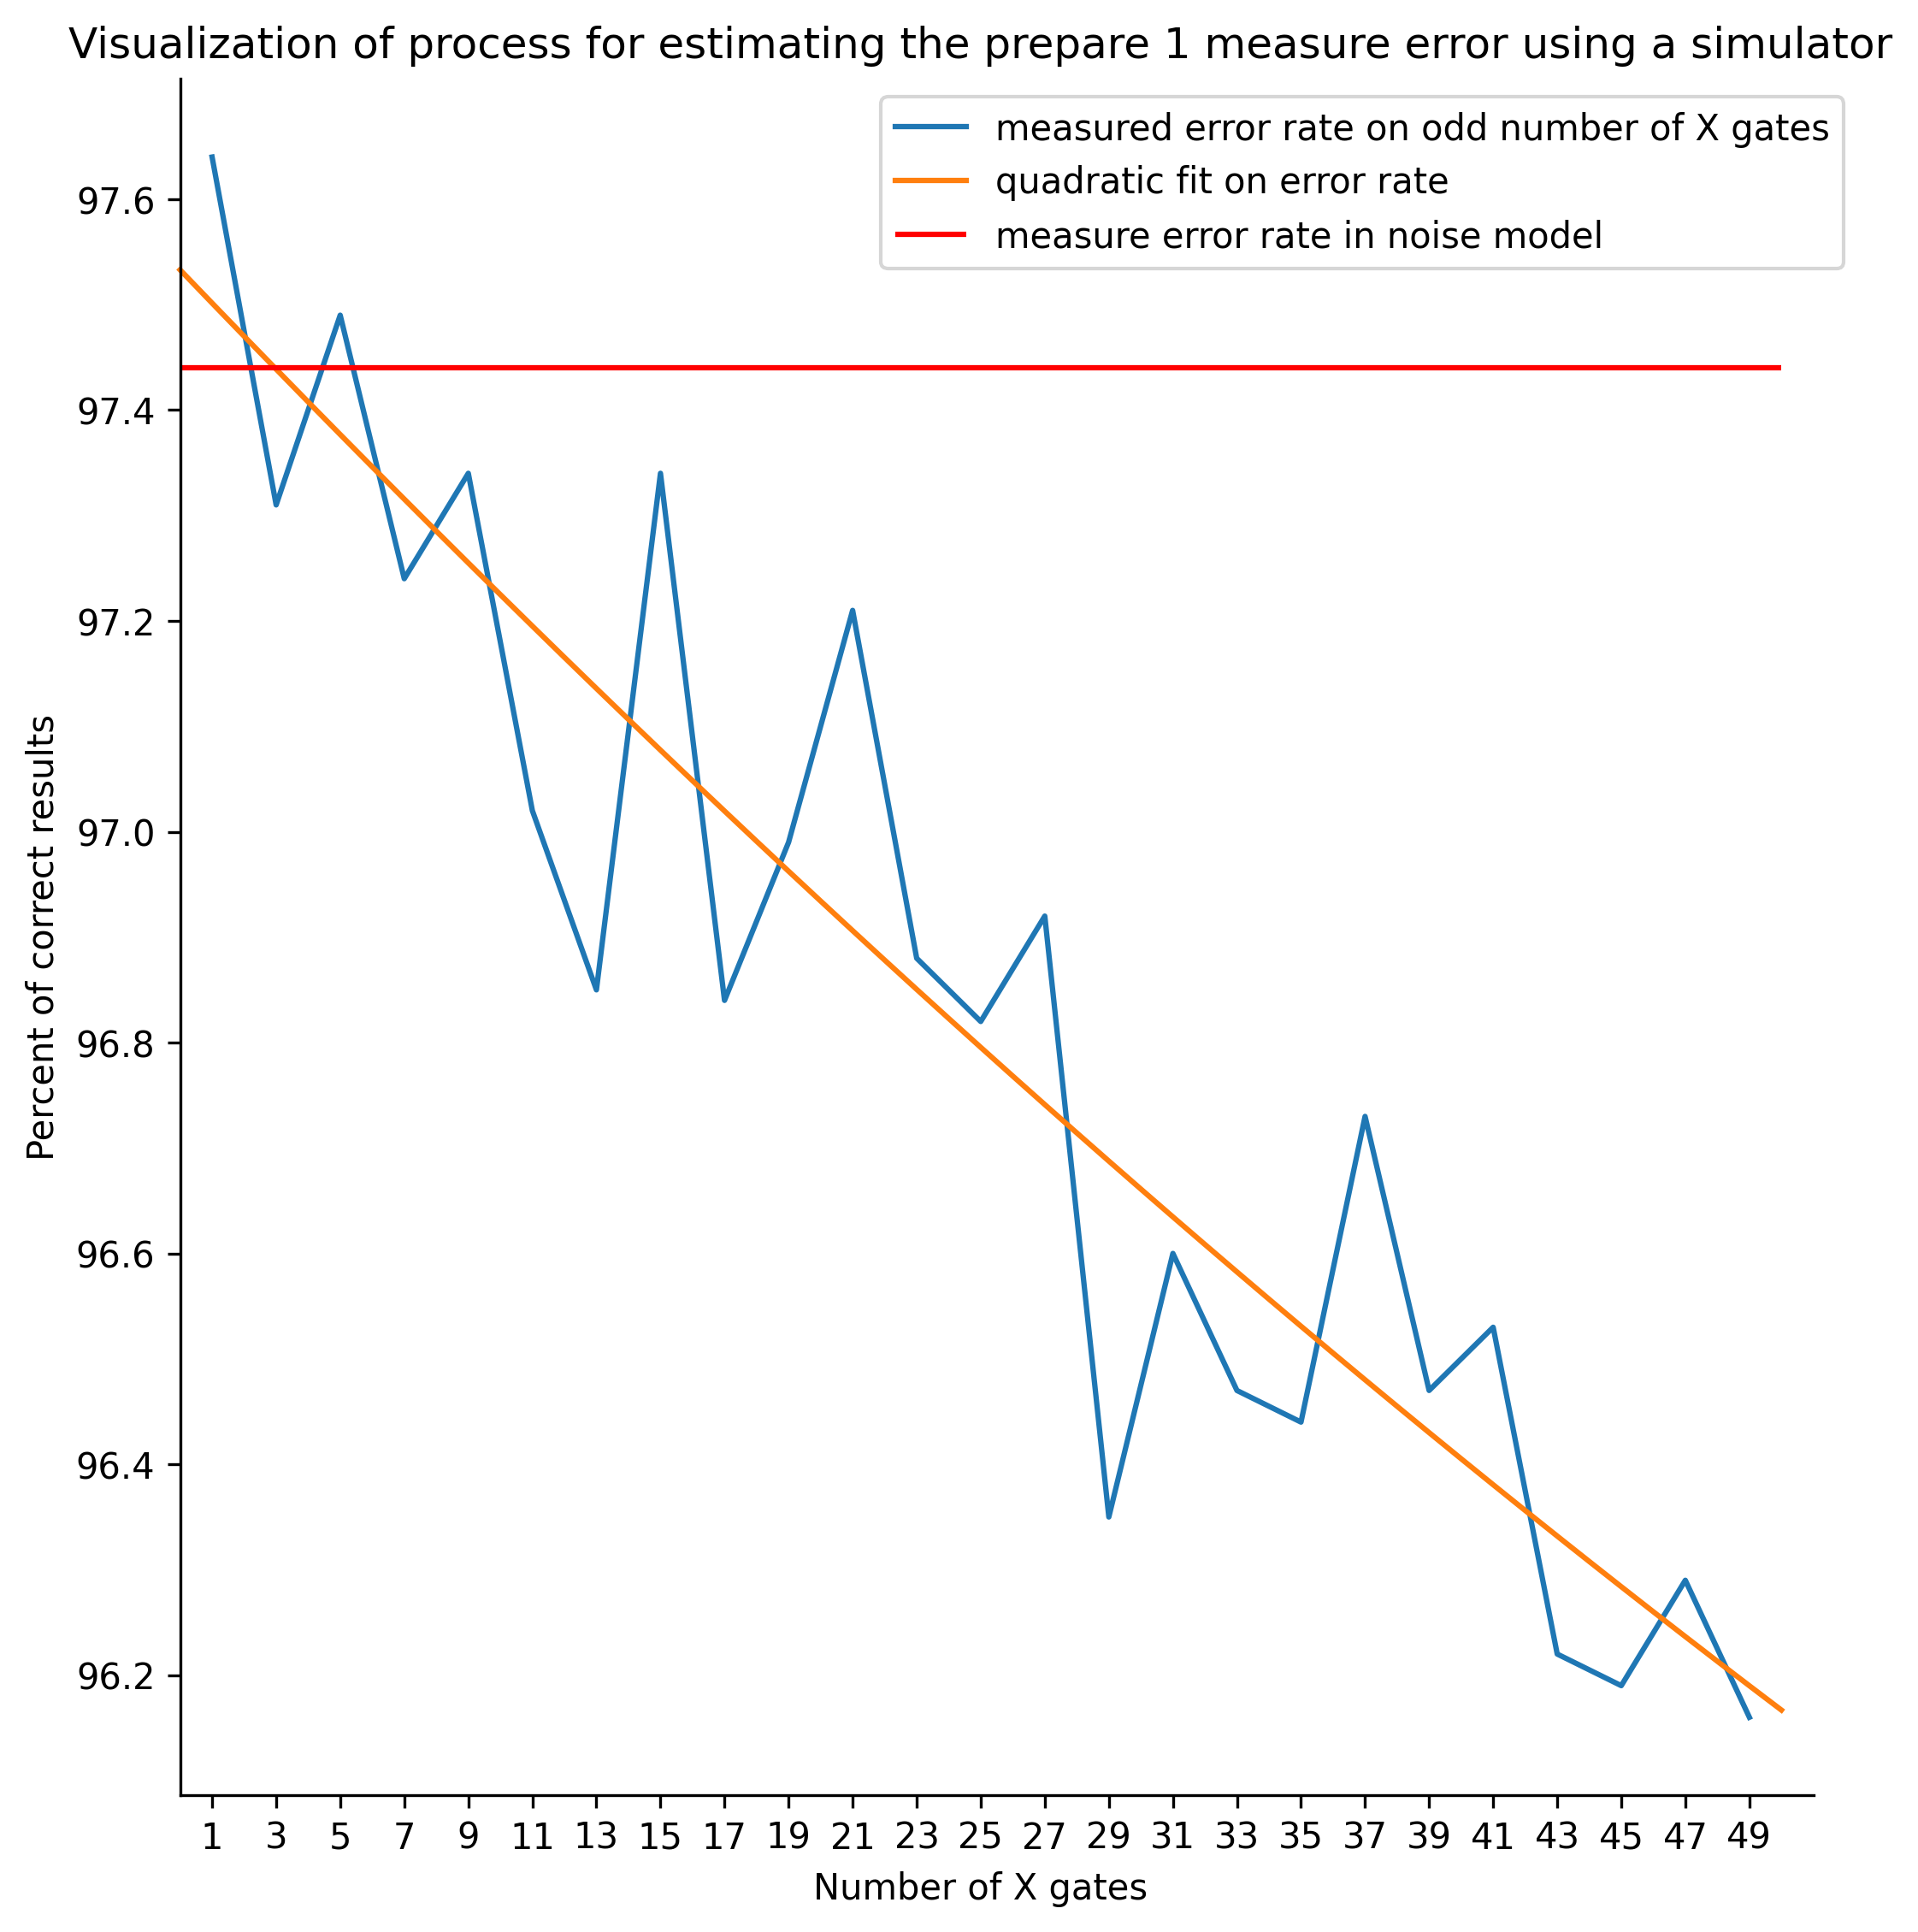

In [27]:
r = np.arange(0, 51, 1)
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
fig = figure(figsize=(figure_width, figure_heigth), dpi=dpi)
ax = fig.add_subplot(111)
ax.set_title("Visualization of process for estimating the prepare 1 measure error using a simulator")
#ax.plot(odd_l, error)
ax.plot(odd_l, error_noisy*100, label="measured error rate on odd number of X gates")
#ax.plot(error_noisy_all)
#ax.plot(r, fit(r))
ax.plot(r, fit_noisy(r)*100, label="quadratic fit on error rate")
ax.hlines(y=readout_error_1*100, xmin=0, xmax=50, color="red", label="measure error rate in noise model")
ax.spines['left'].set_position(("data", 0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_bounds(0, 51)
ax.xaxis.set_ticks(np.arange(1, 50, 2))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel("Number of X gates")
ax.set_ylabel("Percent of correct results")
ax.legend()
fig.savefig("../images/visualization_prepare_1_error.png", bbox_inches='tight')